# 0. Import thư viện + file

In [115]:
import pandas as pd
import numpy as np

In [116]:
job_df_0 = pd.read_csv('C:/Users/admin/.vscode/py/crawl/topcv_08092025.csv')    # Find: Data Analyst 

job_df_1 = pd.read_csv('C:/Users/admin/.vscode/py/crawl/topcv_12092025.csv')    # Find: Phân tích

job_df_2 = pd.read_csv('C:/Users/admin/.vscode/py/crawl/topcv_2_12092025.csv')  # Find: Analyst

In [117]:
print(
    len(job_df_0),
    len(job_df_1),
    len(job_df_2),
    sep='\n'
)

63
212
160


In [118]:
job_df = pd.concat([job_df_0,job_df_1,job_df_2], ignore_index=True)

In [119]:
len(job_df)

435

# **1. CLEAN**

## 1.1 Null values

Require SKill: 3 Null

Additional Skill: 47 null
- **nguyên nhân**: không yêu cầu skills -> để blanks
- **giải quyết**: fillna() thành "Không yêu cầu"

In [120]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Index               435 non-null    int64 
 1   Job Title           435 non-null    object
 2   Salary              435 non-null    object
 3   Place               435 non-null    object
 4   YOE                 435 non-null    object
 5   Company             435 non-null    object
 6   No Employee         435 non-null    object
 7   Industry            435 non-null    object
 8   Require Skill       394 non-null    object
 9   Additional Skill    97 non-null     object
 10  Schedule            435 non-null    object
 11  Detail Description  435 non-null    object
 12  Detail Requirement  435 non-null    object
 13  Detail Benefit      435 non-null    object
 14  URL                 435 non-null    object
dtypes: int64(1), object(14)
memory usage: 51.1+ KB


Double check xem các dòng Null có pattern gì đặc biệt không

-> không có

In [121]:
# job_df.loc[
#     job_df['Require Skill'].isnull() | job_df['Additional Skill'].isnull(),
#     ['Job Title', 'YOE', 'Require Skill', 'Additional Skill', 'Detail Requirement']
# ].sort_values(by = 'Require Skill')

In [122]:
job_df = job_df.fillna({
    'Require Skill': 'Không yêu cầu',
    'Additional Skill': 'Không yêu cầu'
})

In [123]:
job_df.isnull().sum()

Index                 0
Job Title             0
Salary                0
Place                 0
YOE                   0
Company               0
No Employee           0
Industry              0
Require Skill         0
Additional Skill      0
Schedule              0
Detail Description    0
Detail Requirement    0
Detail Benefit        0
URL                   0
dtype: int64

## 1.2 Duplicate values

In [124]:
job_df.duplicated().sum()

np.int64(2)

- Index: set như STT của Jobs -> loại bỏ khi check duplicate
- URL: đuôi html thay đổi theo lần tìm -> loại bỏ khi check duplicate

-> chỉ check duplicate cho 2 cột "Job Title" và "Company"

In [125]:
all_cols = job_df.columns.tolist()
excludde_cols = ['Index', 'URL']

cols_to_check = []
for col in all_cols:
    if col not in excludde_cols:
        cols_to_check.append(col)

cols_to_check

['Job Title',
 'Salary',
 'Place',
 'YOE',
 'Company',
 'No Employee',
 'Industry',
 'Require Skill',
 'Additional Skill',
 'Schedule',
 'Detail Description',
 'Detail Requirement',
 'Detail Benefit']

In [126]:
job_df.duplicated(subset=cols_to_check).sum()

np.int64(91)

In [127]:
job_df.drop_duplicates(subset=cols_to_check, inplace=True)

In [128]:
len(job_df)

344

# **2. ENHANCE STRUCTURE**

# 2.1 YOE

Hướng enhance:
- bỏ từ "năm"
- quy chuẩn
    - "Không yêu cầu" = 0
    - "Dưới" = -0.5
    - "Trên" = +0.5
*eg: Dưới 1 năm = 0.5 YOE*

In [129]:
job_df['YOE'].value_counts()

YOE
2 năm            115
3 năm             85
1 năm             60
Không yêu cầu     35
Dưới 1 năm        16
5 năm             13
4 năm             11
Trên 5 năm         9
Name: count, dtype: int64

In [130]:
job_df['YOE'] = job_df['YOE'].str.replace(' năm', '', regex=False)


In [131]:
def parse_yoe(value):
    value = str(value).lower().strip()

    if 'không yêu cầu' in value:
        return 0.0

    elif 'dưới' in value:
        try:
            return float(value.split()[-1]) - 0.5
        except:
            return None

    elif 'trên' in value:
        return float(value.split()[-1]) + 0.5

    else:
        return float(value.split()[0])

In [132]:
job_df['YOE'] = job_df['YOE'].apply(parse_yoe)

## 2.2 SALARY

Hướng enhance:
- chia data xử lý làm 2 nhóm: VND và USD (dựa vào "USD" hoặc "$").
- clean:
    - **VND**: bỏ "triệu" + đổi "Thoả thuận" thành AVERAGE của những jobs có cùng YOE
    - **USD**: bỏ "USD", "$", ","
- chia làm 2 cột **Salary MIN** và **Salary MAX**
    - tách dựa vào "-"

In [133]:
job_df['Salary'].value_counts(0)

Salary
Thoả thuận           162
15 - 25 triệu         14
15 - 20 triệu         13
10 - 15 triệu         10
20 - 25 triệu          6
                    ... 
18 - 22 triệu          1
7 - 12 triệu           1
1,800 - 2,500 USD      1
11 - 20 triệu          1
20 - 24 triệu          1
Name: count, Length: 95, dtype: int64

**Step làm** 

Tạo mask (để phân nhóm USD) -> xử lý nhóm VND / USD -> Salary MIN - MAX theo VND -> ghi đè USD dựa vào mask

In [134]:
# ExR
USD_TO_VND = 25450

# [STEP 1] tạo mask: chứa USD hoặc $
usd_mask = job_df['Salary'].str.contains('USD|\\$', na=False, case=False)


# [STEP 2] clean từng nhóm

# case 1: VND
salary_vnd = job_df.loc[~usd_mask, 'Salary']
salary_vnd_1 = salary_vnd.str.replace('triệu', '', regex=False).str.strip()
salary_vnd_2 = salary_vnd_1.replace('Thoả thuận', pd.NA)
vnd_min_max = salary_vnd_2.str.split('-', expand=True)

# case 2: USD
salary_usd = job_df.loc[usd_mask, 'Salary']
# loại bỏ USD $ ,  =>  output: 0 - 0
cleaned_usd = salary_usd.str.replace(',', '', regex=False).str.replace(r'(?i)\s*USD|\$', '', regex=True).str.strip()
usd_min_max = cleaned_usd.str.split('-', expand=True)


# [STEP 3] Salary MIN - MAX
job_df['Salary MIN'] = pd.to_numeric(vnd_min_max[0], errors='coerce')
job_df['Salary MAX'] = pd.to_numeric(vnd_min_max[1], errors='coerce')


# [STEP 4] đè USD theo mask
if not usd_min_max.empty:
    usd_min = pd.to_numeric(usd_min_max[0], errors='coerce') * USD_TO_VND / 1_000_000   #(/1_000_000 vì đơn vị VND = triệu)
    usd_max = pd.to_numeric(usd_min_max[1], errors='coerce') * USD_TO_VND / 1_000_000
    
    usd_max.fillna(usd_min, inplace=True)

    job_df.loc[usd_mask, 'Salary MIN'] = usd_min
    job_df.loc[usd_mask, 'Salary MAX'] = usd_max

Check các job có lương "Thoả thuận" xem có pattern gì đặc biệt không

-> không có

In [135]:
# Tính số lượng "Thoả thuận" theo YOE
thoathuan_count = job_df.loc[job_df['Salary'] == 'Thoả thuận'].groupby('YOE')['Salary'].count().rename('thỏa thuận')

# Tính tổng số bản ghi theo YOE
total_count = job_df.groupby('YOE')['Salary'].count().rename('total')

merge = pd.merge(thoathuan_count, total_count, how='inner',on='YOE')
merge

,thỏa thuận,total
YOE,,
0.0,18,35
0.5,7,16
1.0,26,60
2.0,45,115
3.0,43,85
4.0,8,11
5.0,7,13
5.5,8,9


In [136]:
# average range theo YOE
yoe_group_salary = job_df.groupby('YOE').agg(
    min_salary = ('Salary MIN', 'mean'),
    max_salary = ('Salary MAX', 'mean')
).round(2)
yoe_group_salary


,min_salary,max_salary
YOE,,
0.0,5.56,11.71
0.5,11.29,18.29
1.0,12.95,21.14
2.0,15.46,23.37
3.0,18.76,29.40
4.0,22.33,33.33
5.0,30.33,40.00
5.5,NaN,NaN


In [137]:
# fillna = average các job có chung YOE
job_df['Salary MIN'] = job_df['Salary MIN'].fillna(
    job_df.groupby('YOE')['Salary MIN'].transform('mean')
)

job_df['Salary MAX'] = job_df['Salary MAX'].fillna(
    job_df.groupby('YOE')['Salary MAX'].transform('mean')
)

job_df[['Salary MIN', 'Salary MAX']] = job_df[['Salary MIN', 'Salary MAX']].round(2)

## 2.3 No. EMP

Hướng enhance:
- Tạo cột mới "Company Type", chia làm 5 nhóm dựa vào số lượng nhân viên MIN (x)
    - Startup: x <10
    - Doanh nghiệp nhỏ: x <50
    - Doanh nghiệp vừa: x <200
    - Doanh nghiệp lớn: x <1000
    - Tập đoàn: số lượng x >1000 
- Số lượng nhân viên MIN = x tính dựa vào
    - nếu **# - #**: thì **x = # trước dấu "-"**
    - nếu **#+**: thì **x = #**

In [138]:
job_df['No Employee'].value_counts()

No Employee
100-499 nhân viên     109
25-99 nhân viên        73
1000+ nhân viên        62
500-1000 nhân viên     47
5000+ nhân viên        21
10-24 nhân viên        14
10000+ nhân viên       14
1-9 nhân viên           2
3000+ nhân viên         2
Name: count, dtype: int64

In [139]:
emp_clean1 = job_df['No Employee'].str.replace('nhân viên', '', regex=False).str.strip()

job_df['emp_min'] = pd.to_numeric( salary_2.str.split('-', expand=True)[0] , errors='coerce' )

job_df['Company Type'] = job_df['emp_min'].apply(
    lambda x: (
        'Startup' if x <= 10 else
        'Doanh nghiệp nhỏ' if x <= 50 else
        'Doanh nghiệp vừa' if x <= 200 else
        'Doanh nghiệp lớn' if x <= 1000 else
        'Tập đoàn'
    )
)

In [140]:
job_df['Company Type'].value_counts()

Company Type
Tập đoàn            186
Doanh nghiệp nhỏ    111
Startup              44
Doanh nghiệp lớn      2
Doanh nghiệp vừa      1
Name: count, dtype: int64

## 2.4 SCHEDULE

Hướng enhance
- Chia làm 2 nhóm:
    - **T2-T7**: làm việc đến thứ 7: *nếu "Schedule" chứa các từ "thứ 7" hoặc "thứ bảy" thì thuộc nhóm này*
    - **T2-T6**: làm việc đến thứ 6: *còn lại*



In [141]:
# # DROP HƯỚNG NÀY
# # regexp
# pattern = r"(Thứ\s?\d\s?-\s?Thứ\s?\d\s?\(.*?\))"
# # pattern
# y = job_df['Schedule'].str.extract(pattern, expand=False)

In [142]:
job_df['Work Day'] = np.where(
    job_df['Schedule'].str.contains('Thứ 7', case=False)
    | job_df['Schedule'].str.contains('thứ bảy', case=False),
    'T2-T7',
    'T2-T6'
)

In [143]:
job_df['Work Day'].value_counts()

Work Day
T2-T6    237
T2-T7    107
Name: count, dtype: int64

## 2.5 REQUIRE + ADDITIONAL (**SKILL**)

 Step enhance
 - Step 1: ChatGPT gen ra những technical skills cần thiết với vị trí DA
 - Step 2: dùng **REGEXP** check ở các cột 'Require Skill', 'Additional Skill' và 'Detail Requirement'
 - Step 3: trả output là 1 DataFrame mới gồm:
    - 2 cột gốc là "Index" và "Job Title"
    - những cột còn lại tiêu đề là *tools technical ở step1*, giá trị là *Y/N* (Y nếu job có yêu cầu tools này, N là không yêu cầu)

In [144]:
# dictionary with tools + regexp
patterns = {
    'SQL': r'(?<!no)\bsql\b|mysql|postgresql|postgres|\bt-?sql\b|pl/?sql|sql server',
    'Python': r'\bpython\b',
    'R': r'(?<!\w)r(?!\w)|\br language\b',
    'Excel': r'\bexcel\b',
    'Tableau': r'\btableau\b',
    'PowerBI': r'\bpower\s*bi\b',
    'ETL': r'\betl\b',
    'Airflow': r'\bairflow\b',
    'Spark': r'\bspark\b',
    'AWS': r'\baws\b|amazon web services',
    'Azure': r'\bazure\b',
    'GCP': r'\bgcp\b|google cloud',
    'Snowflake': r'\bsnowflake\b',
}

In [145]:
job_df_tools = job_df[['Index', 'Job Title', 'Require Skill', 'Additional Skill', 'Detail Requirement']].copy() 

for tool, regexp in patterns.items():
    job_df_tools[tool] = np.where(
        job_df_tools['Require Skill'].str.contains(regexp, case=False, regex=True) |
        job_df_tools['Additional Skill'].str.contains(regexp, case=False, regex=True) |
        job_df_tools['Detail Requirement'].str.contains(regexp, case=False, regex=True),
        'Y', 'N'
    )

In [146]:
del job_df_tools['Detail Requirement']
del job_df_tools['Require Skill']
del job_df_tools['Additional Skill']

job_df_tools.head()

,Index,Job Title,SQL,Python,R,Excel,Tableau,PowerBI,ETL,Airflow,Spark,AWS,Azure,GCP,Snowflake
0,1,Chuyên Viên Phân Tích Dữ Liệu (Data Analyst),Y,Y,N,N,Y,Y,N,N,N,Y,N,N,N
1,2,Financial Planning & Analysis Executive (FP&A),Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N
2,3,Nhân Viên Giám Sát & Phân Tích Dữ Liệu - Tổng ...,N,N,N,Y,N,N,N,N,N,N,N,N,N
3,4,Thực Tập Sinh ERP - Data Analyst,N,N,N,N,N,N,N,N,N,N,N,N,N
4,5,Trưởng Nhóm Phân Tích Dữ Liệu - Ngành Tài Chính,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N


## 2.6 COMPANY

Xóa bỏ cụm "Pro Company" trong phần tên công ty
- nguyên nhân: các công ty hàng đầu sẽ được gán cụm này trên TopCV

In [147]:
job_df['Company'] = job_df['Company'].str.replace('\n', '', regex=False).str.strip()

job_df['Company'] = job_df['Company'].str.replace('Pro Company', '', regex=False).str.strip()

## 2.7 Benefits

 Step enhance
 - Step 1: ChatGPT gen ra những Benefits thường có
 - Step 2: dùng **REGEXP** check ở cột **Detail Benefits**
 - Step 3: trả output là 1 DataFrame mới gồm:
    - 2 cột gốc là "Index" và "Job Title"
    - những cột còn lại tiêu đề là *benefits ở step1*, giá trị là *Y/N* (Y nếu job có benefits này, N là không yêu cầu)

In [148]:
benefit_patterns = {
    'Bảo hiểm xã hội (BHXH)': r'\bbhxh\b|\bbảo hiểm xã hội\b',
    'Bảo hiểm y tế (BHYT)': r'\bbhyt\b|\bbảo hiểm y tế\b',
    'Bảo hiểm sức khỏe': r'\bbảo hiểm sức khỏe\b|health insurance',
    'Bảo hiểm tai nạn': r'\bbảo hiểm tai nạn\b',
    'Thưởng tháng 13': r'thưởng.*(?:lương)?.*tháng\s*13|\btháng\s*13\b',
    'Thưởng lễ, Tết': r'thưởng.*(?:tết|lễ)',
    'Mức lương / Thu nhập': r'\bmức lương\b|\bthu nhập\b|\bsalary\b',
    'Tăng lương': r'tăng lương|xét tăng lương',
    'Nghỉ phép (12 ngày)': r'\b12\s*ngày\s*phép\b|nghỉ phép|annual leave',
    'Du lịch / Company Trip': r'du lịch|company trip|nghỉ mát',
    'Teambuilding': r'teambuilding|team building',
    'Khám sức khỏe định kỳ': r'khám sức khỏe định kỳ|khám sức khỏe hàng năm',
    'Đào tạo / Khóa học': r'đào tạo|khóa học|training|phát triển cá nhân',
    'Cơ hội phát triển nghề nghiệp': r'cơ hội phát triển|phát triển nghề nghiệp',
    'Môi trường làm việc năng động': r'môi trường.*(?:năng động|trẻ trung|thân thiện|chuyên nghiệp)',
}

In [149]:
job_df_benefit = job_df[['Index', 'Job Title', 'Detail Benefit']].copy() 

for benefit, regexp in benefit_patterns.items():
    job_df_benefit[benefit] = np.where(
        job_df_benefit['Detail Benefit'].str.contains(regexp, case=False, regex=True),
        'Y', 'N'
    )

In [150]:
del job_df_benefit['Detail Benefit']

job_df_benefit.head()

,Index,Job Title,Bảo hiểm xã hội (BHXH),Bảo hiểm y tế (BHYT),Bảo hiểm sức khỏe,Bảo hiểm tai nạn,Thưởng tháng 13,"Thưởng lễ, Tết",Mức lương / Thu nhập,Tăng lương,Nghỉ phép (12 ngày),Du lịch / Company Trip,Teambuilding,Khám sức khỏe định kỳ,Đào tạo / Khóa học,Cơ hội phát triển nghề nghiệp,Môi trường làm việc năng động
0,1,Chuyên Viên Phân Tích Dữ Liệu (Data Analyst),N,N,Y,N,N,N,Y,N,Y,N,N,N,N,N,N
1,2,Financial Planning & Analysis Executive (FP&A),Y,Y,N,N,Y,Y,Y,N,N,Y,N,Y,Y,N,Y
2,3,Nhân Viên Giám Sát & Phân Tích Dữ Liệu - Tổng ...,Y,N,N,N,N,N,N,N,N,N,Y,N,Y,N,Y
3,4,Thực Tập Sinh ERP - Data Analyst,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,Y
4,5,Trưởng Nhóm Phân Tích Dữ Liệu - Ngành Tài Chính,Y,Y,Y,N,Y,Y,Y,N,Y,N,Y,N,N,N,N


# 3. **FINAL**

Output gồm 2 file CSV
- [File 1] Job Final: trích xuất các cột cần thiết từ DataFrame gốc
- [File 2] Job Tools: là phần skills được trích xuất ra - với **Foreign Key** là cột **Index**
- [File 3] Job Benefits: là phần benefit được trích xuất ra - với **Foreign Key** là cột **Index**

In [151]:
job_final = job_df[['Index', 'Job Title', 'YOE', 'Salary MIN', 'Salary MAX', 'Place', 'Work Day', 'Company Type', 'Company', 'Industry', 'URL']]

In [152]:
job_final

,Index,Job Title,YOE,Salary MIN,Salary MAX,Place,Work Day,Company Type,Company,Industry,URL
0,1,Chuyên Viên Phân Tích Dữ Liệu (Data Analyst),3.0,20.00,39.00,Hà Nội,T2-T6,Doanh nghiệp nhỏ,CÔNG TY TNHH CÁC GIẢI PHÁP SOFTEL,IT - Phần mềm,https://www.topcv.vn/viec-lam/chuyen-vien-phan...
1,2,Financial Planning & Analysis Executive (FP&A),1.0,12.95,21.14,Hồ Chí Minh,T2-T6,Tập đoàn,Công ty Cổ phần Thế Giới Số (DIGIWORLD),Thương mại điện tử,https://www.topcv.vn/viec-lam/financial-planni...
2,3,Nhân Viên Giám Sát & Phân Tích Dữ Liệu - Tổng ...,1.0,12.95,21.14,Hồ Chí Minh,T2-T6,Tập đoàn,Công Ty TNHH Bảo Hiểm Tasco,Bảo hiểm,https://www.topcv.vn/viec-lam/nhan-vien-giam-s...
3,4,Thực Tập Sinh ERP - Data Analyst,0.0,5.56,11.71,Hà Nội,T2-T7,Tập đoàn,CÔNG TY CỔ PHẦN BÁCH LIÊN,Xuất nhập khẩu,https://www.topcv.vn/viec-lam/thuc-tap-sinh-er...
4,5,Trưởng Nhóm Phân Tích Dữ Liệu - Ngành Tài Chính,1.0,12.95,21.14,Hồ Chí Minh,T2-T7,Tập đoàn,GALAXY DEBT TRADING COMPANY LIMITED,Tài chính,https://www.topcv.vn/viec-lam/truong-nhom-phan...
...,...,...,...,...,...,...,...,...,...,...,...
420,23,Executive Assistant Of Ceo (Focus Data),5.5,NaN,NaN,Hồ Chí Minh,T2-T6,Tập đoàn,Công ty Cổ phần Xuất nhập khẩu Bến Tre,Sản xuất,https://www.topcv.vn/viec-lam/executive-assist...
426,31,Product Business Analyst/Product Analyst,3.0,18.76,29.40,Hà Nội,T2-T6,Tập đoàn,CÔNG TY TNHH MỘT THÀNH VIÊN AN NINH MẠNG VIETTEL,IT - Phần mềm,https://www.topcv.vn/viec-lam/product-business...
430,35,Data Analyst,3.0,18.76,29.40,Hà Nội,T2-T6,Tập đoàn,CÔNG TY TNHH MỘT THÀNH VIÊN AN NINH MẠNG VIETTEL,IT - Phần mềm,https://www.topcv.vn/viec-lam/data-analyst/186...
431,36,SOC Analyst (Tier 1),1.0,12.95,21.14,"Hà Nội, Hồ Chí Minh",T2-T6,Tập đoàn,CÔNG TY TNHH MỘT THÀNH VIÊN AN NINH MẠNG VIETTEL,IT - Phần mềm,https://www.topcv.vn/viec-lam/soc-analyst-tier...


In [153]:
job_df_tools

,Index,Job Title,SQL,Python,R,Excel,Tableau,PowerBI,ETL,Airflow,Spark,AWS,Azure,GCP,Snowflake
0,1,Chuyên Viên Phân Tích Dữ Liệu (Data Analyst),Y,Y,N,N,Y,Y,N,N,N,Y,N,N,N
1,2,Financial Planning & Analysis Executive (FP&A),Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N
2,3,Nhân Viên Giám Sát & Phân Tích Dữ Liệu - Tổng ...,N,N,N,Y,N,N,N,N,N,N,N,N,N
3,4,Thực Tập Sinh ERP - Data Analyst,N,N,N,N,N,N,N,N,N,N,N,N,N
4,5,Trưởng Nhóm Phân Tích Dữ Liệu - Ngành Tài Chính,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,23,Executive Assistant Of Ceo (Focus Data),Y,N,N,Y,Y,Y,N,N,N,N,N,N,N
426,31,Product Business Analyst/Product Analyst,Y,N,N,N,N,N,N,N,N,N,N,N,N
430,35,Data Analyst,Y,Y,Y,N,Y,Y,N,N,N,N,N,N,N
431,36,SOC Analyst (Tier 1),N,N,N,N,N,N,N,N,N,N,N,N,N


In [154]:
job_df_benefit

,Index,Job Title,Bảo hiểm xã hội (BHXH),Bảo hiểm y tế (BHYT),Bảo hiểm sức khỏe,Bảo hiểm tai nạn,Thưởng tháng 13,"Thưởng lễ, Tết",Mức lương / Thu nhập,Tăng lương,Nghỉ phép (12 ngày),Du lịch / Company Trip,Teambuilding,Khám sức khỏe định kỳ,Đào tạo / Khóa học,Cơ hội phát triển nghề nghiệp,Môi trường làm việc năng động
0,1,Chuyên Viên Phân Tích Dữ Liệu (Data Analyst),N,N,Y,N,N,N,Y,N,Y,N,N,N,N,N,N
1,2,Financial Planning & Analysis Executive (FP&A),Y,Y,N,N,Y,Y,Y,N,N,Y,N,Y,Y,N,Y
2,3,Nhân Viên Giám Sát & Phân Tích Dữ Liệu - Tổng ...,Y,N,N,N,N,N,N,N,N,N,Y,N,Y,N,Y
3,4,Thực Tập Sinh ERP - Data Analyst,N,N,N,N,N,N,N,N,N,N,N,N,Y,Y,Y
4,5,Trưởng Nhóm Phân Tích Dữ Liệu - Ngành Tài Chính,Y,Y,Y,N,Y,Y,Y,N,Y,N,Y,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,23,Executive Assistant Of Ceo (Focus Data),N,N,Y,N,N,N,Y,N,Y,N,N,N,N,N,N
426,31,Product Business Analyst/Product Analyst,Y,N,Y,N,N,Y,Y,N,Y,Y,Y,Y,N,N,N
430,35,Data Analyst,Y,N,Y,N,N,Y,Y,N,Y,Y,Y,Y,N,N,N
431,36,SOC Analyst (Tier 1),N,N,N,N,N,N,Y,N,Y,N,Y,N,N,N,N


In [155]:
# Xuất CSV: C:/Users/admin/.vscode/py/crawl/output_clean/
job_final.to_csv('C:/Users/admin/.vscode/py/crawl/output_clean/job_12092025.csv', index=False, encoding='utf-8-sig')

job_df_tools.to_csv('C:/Users/admin/.vscode/py/crawl/output_clean/job_tools_12092025.csv', index=False, encoding='utf-8-sig')

job_df_benefit.to_csv('C:/Users/admin/.vscode/py/crawl/output_clean/job_df_benefit_12092025.csv', index=False, encoding='utf-8-sig')

# 4. INSIGHTS

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
# sns.set_style('whitegrid')
sns.set_style('white')

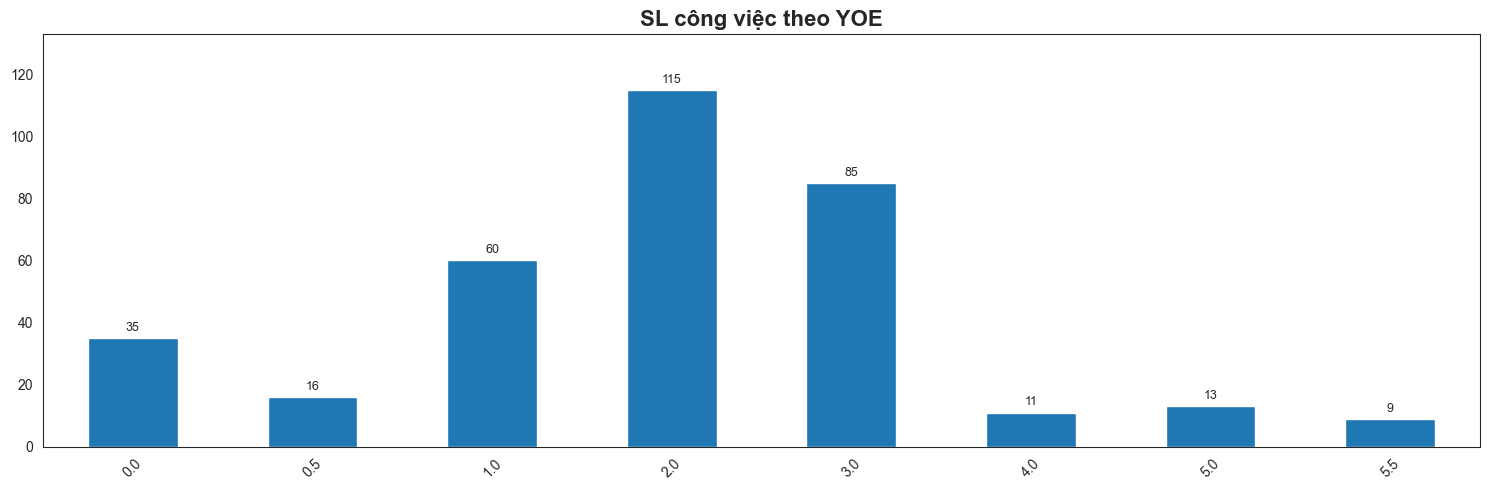

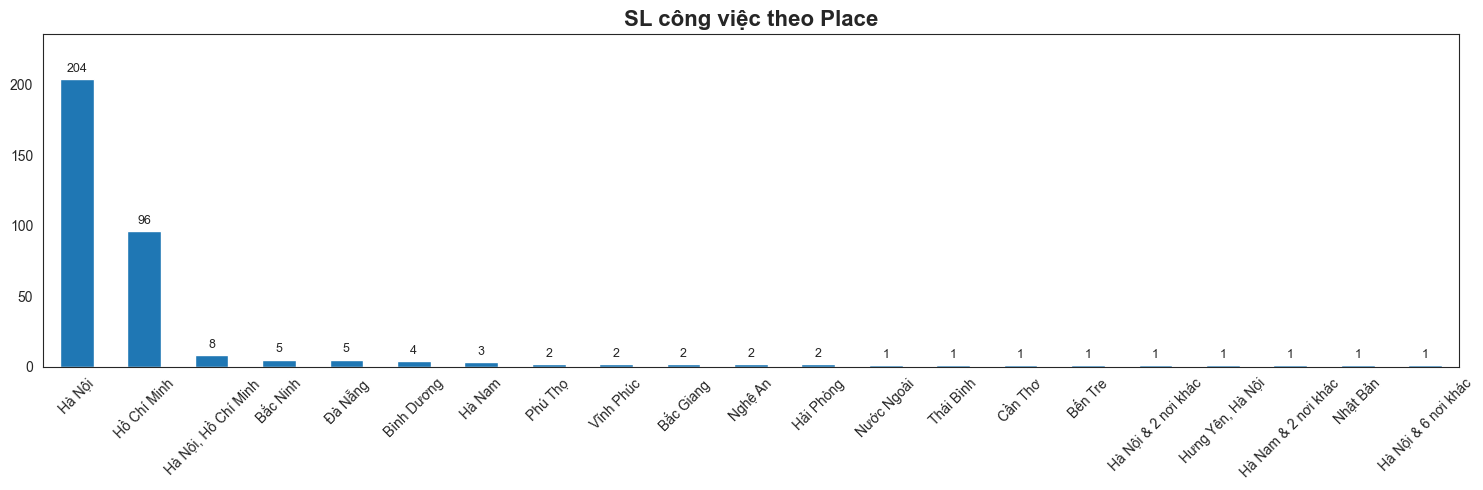

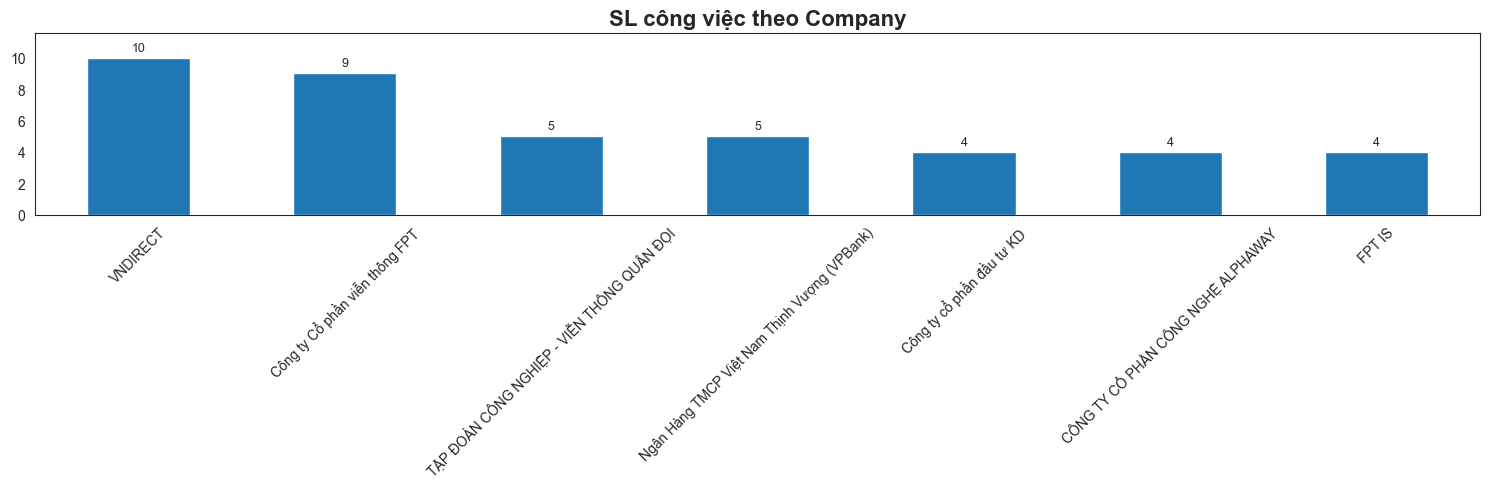

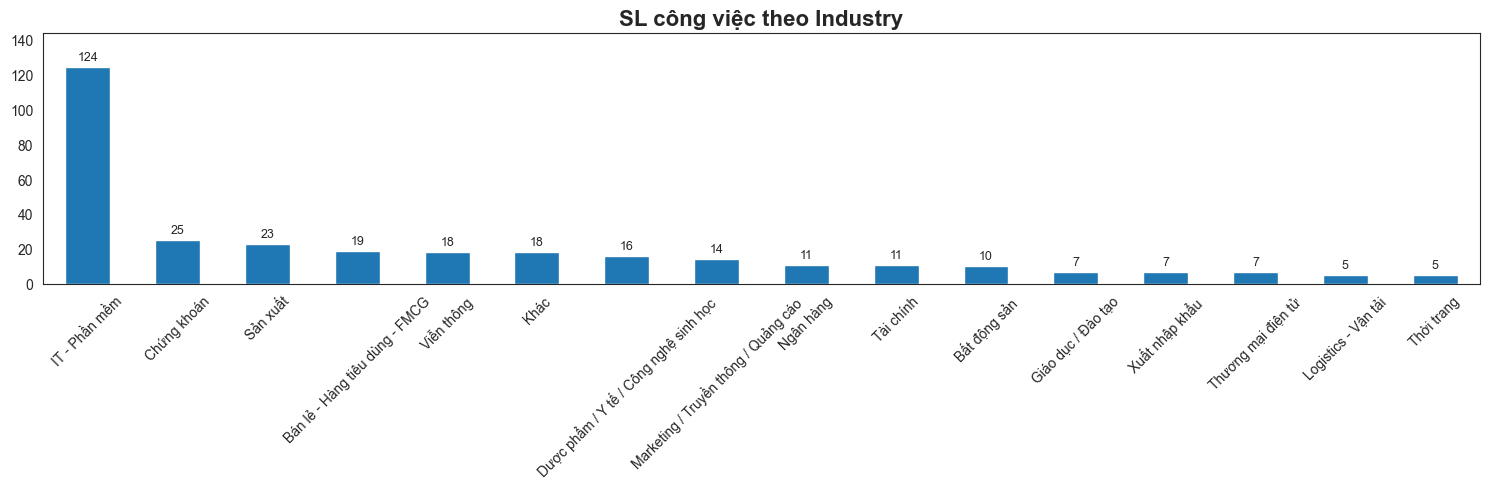

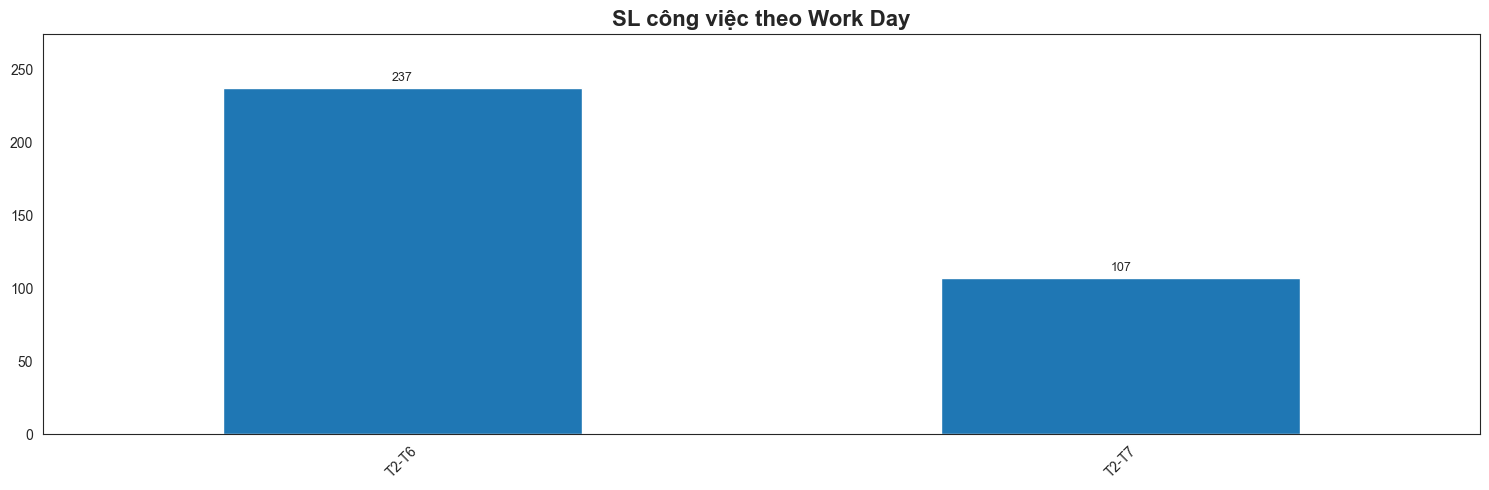

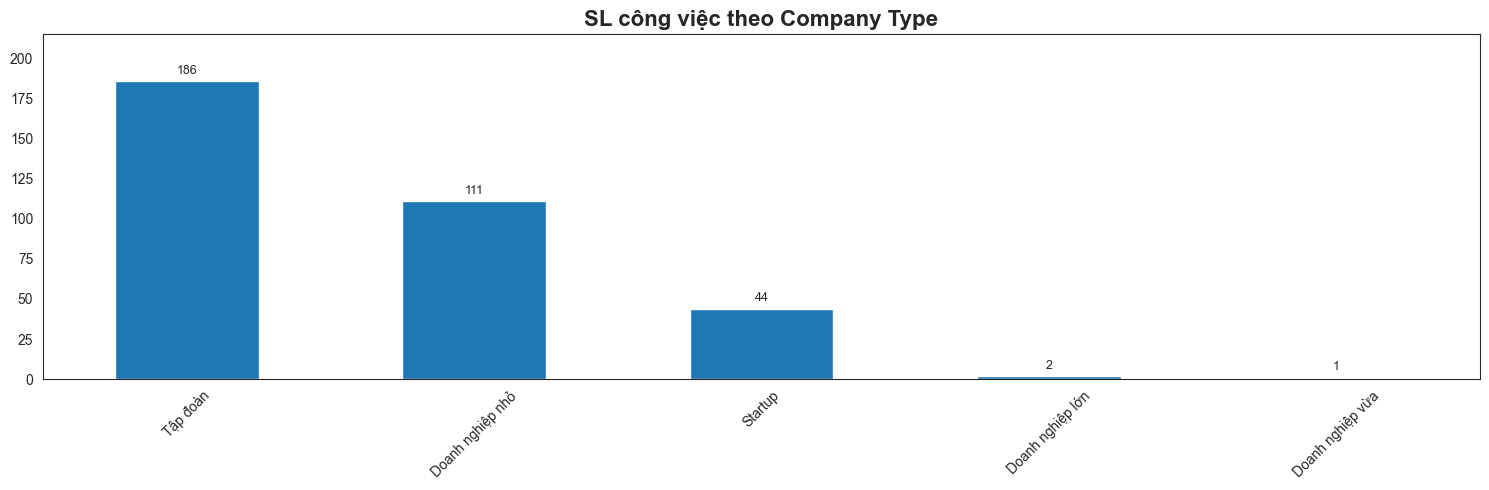

In [158]:
cols = ['YOE', 'Place', 'Company', 'Industry', 'Work Day', 'Company Type']

for column in cols:
    job_amount = job_final[column].value_counts()

    # TH đặc biệt
    if column in ['Company', 'Industry']:   # cột company + industry nhiều values => giới hạn
        data = job_amount[job_amount >= 4]
    else:
        data = job_amount
    if data.empty:                          # giới hạn mà blanks thì bỏ qua
        continue
    if column == 'YOE':                     # với YOE thì sort theo index (YOE)
        data = data.sort_index()

    fig, ax  = plt.subplots(figsize=(15, 5))
    data.plot(kind='bar', x=data.index.astype(str), y=data.values, ax=ax, rot=45)

    title = 'SL công việc theo {}'.format(column)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('')

    current_max_ylim = ax.get_ylim()[1]
    ax.set_ylim(0, current_max_ylim * 1.1)

    if not data.empty:
        ax.bar_label(ax.containers[0], fontsize=9, padding=3)

    plt.tight_layout()
    plt.show()

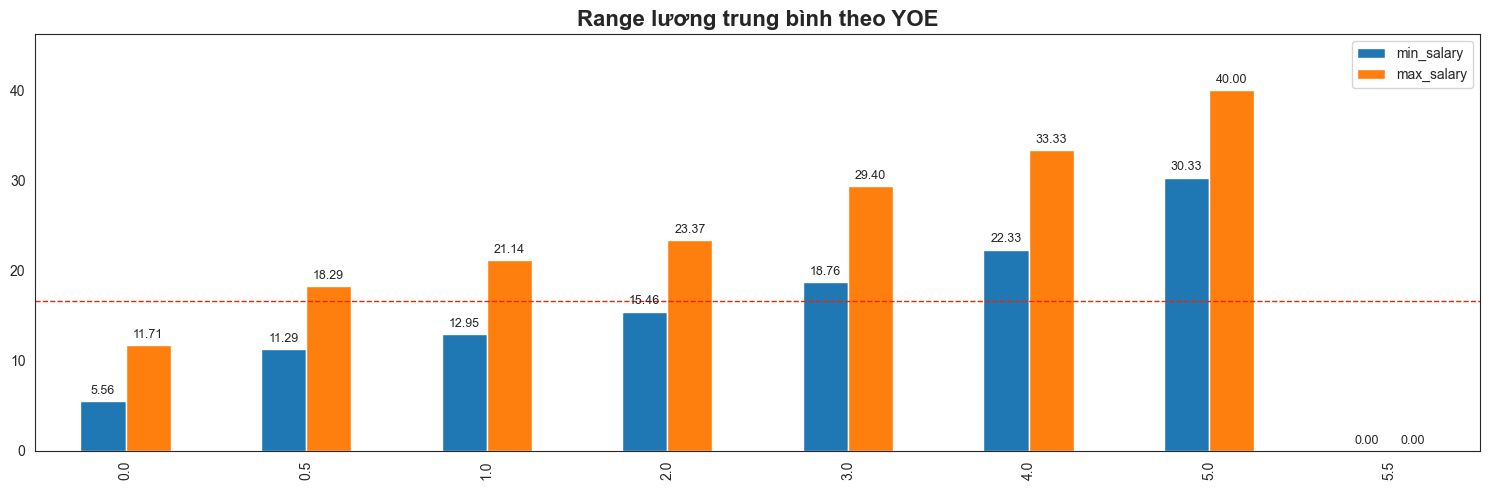

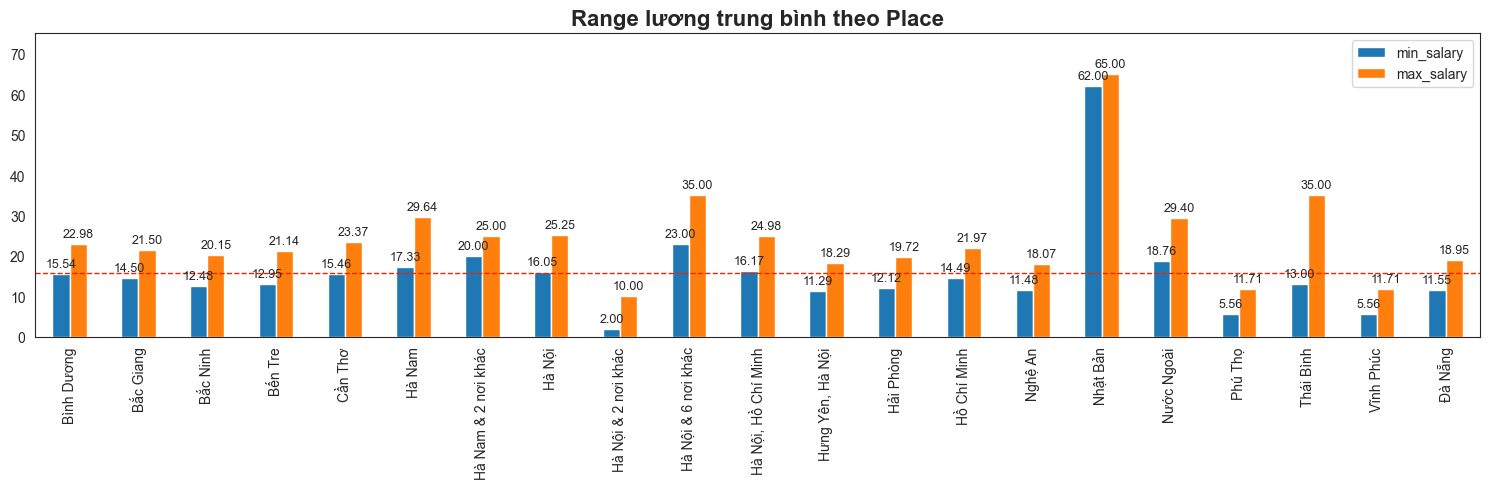

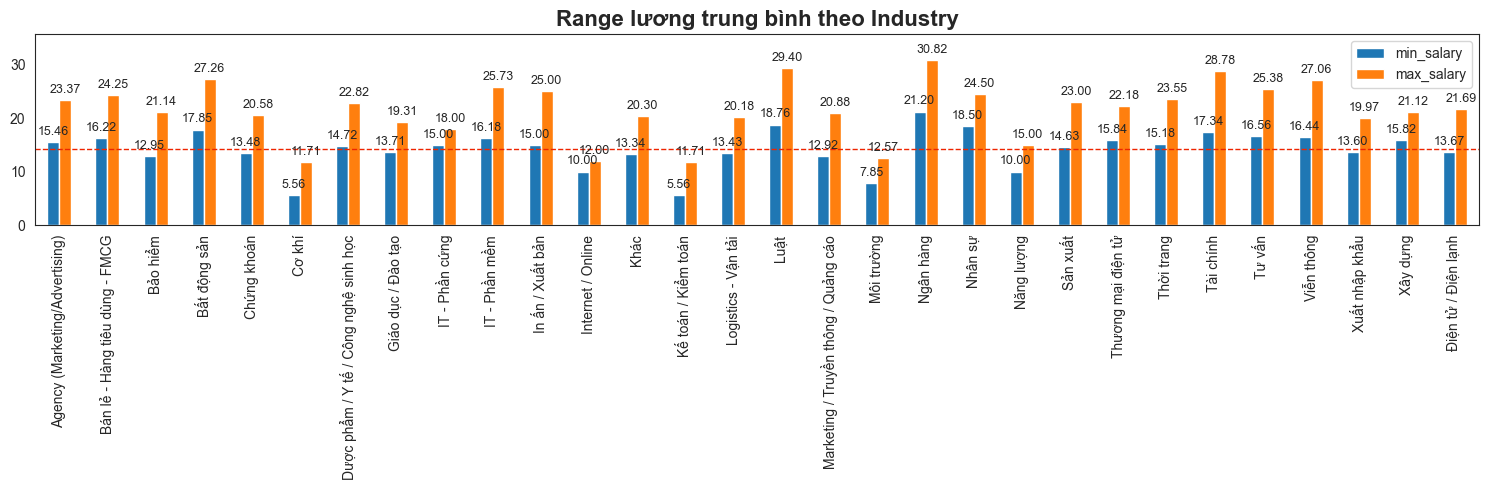

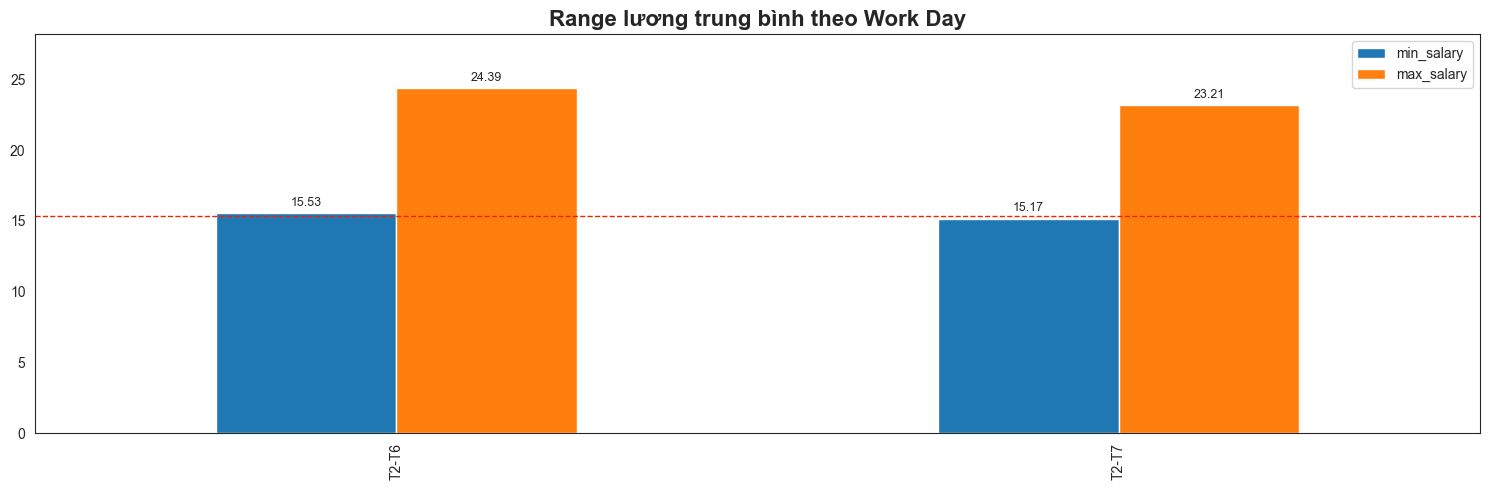

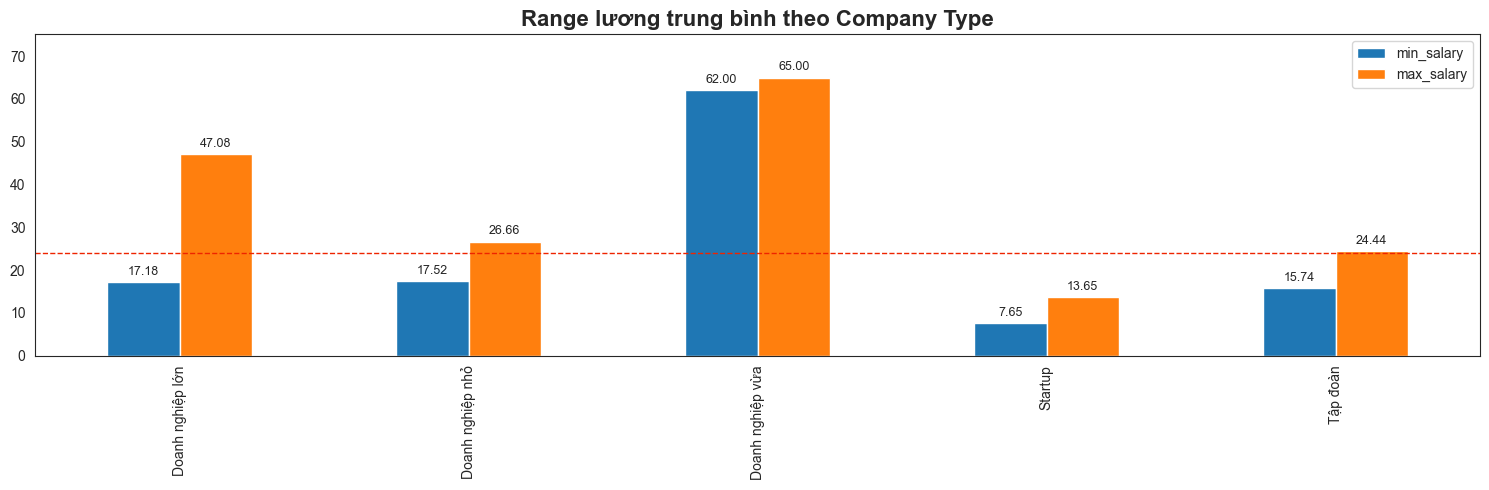

In [159]:
cols = ['YOE', 'Place', 'Industry', 'Work Day', 'Company Type']

for column in cols:
    calc_groupby = job_final.groupby(column).agg(
        min_salary=('Salary MIN', 'mean'),
        max_salary=('Salary MAX', 'mean')
    ).round(2).reset_index()

    overall_avg_max_salary = calc_groupby['min_salary'].mean()

    if column == 'YOE':
        calc_groupby = calc_groupby.sort_values(by=column, ascending=True)


    fig, ax = plt.subplots(figsize=(15, 5))
    calc_groupby.plot(kind='bar', x=column, y=['min_salary', 'max_salary'], stacked=False, ax=ax)

    ax.axhline(y=overall_avg_max_salary, color='#ee2400', linestyle='--', linewidth=1)

    title = 'Range lương trung bình theo {}'.format(column)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9, padding=3)

    current_max_ylim = ax.get_ylim()[1]
    ax.set_ylim(0, current_max_ylim * 1.1)

    plt.tight_layout()
    plt.show()

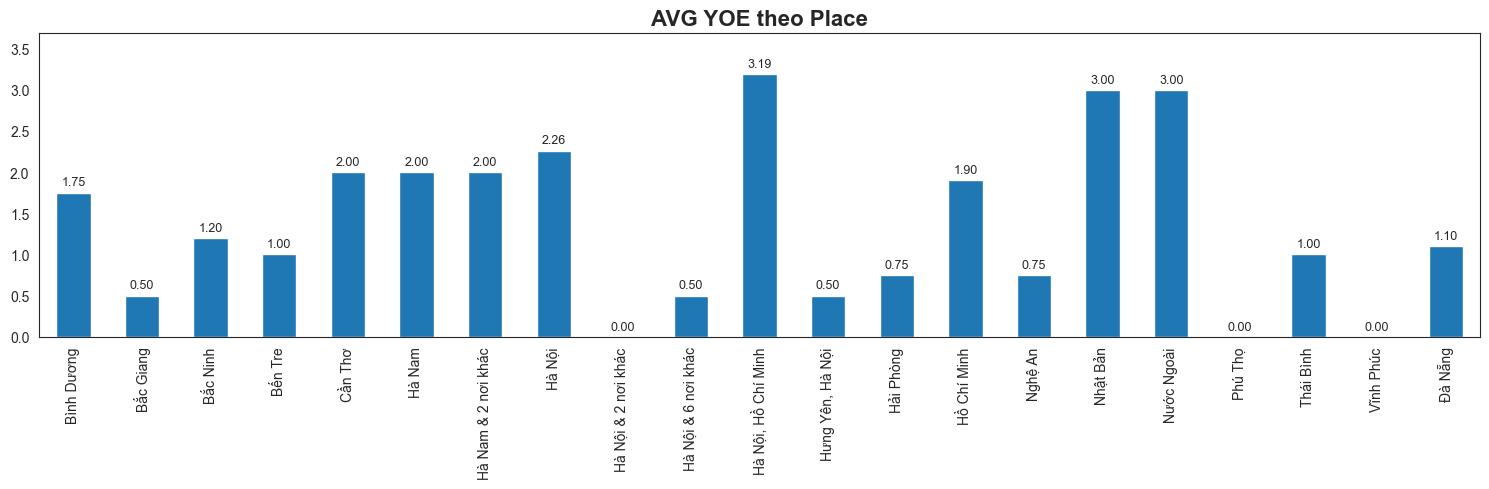

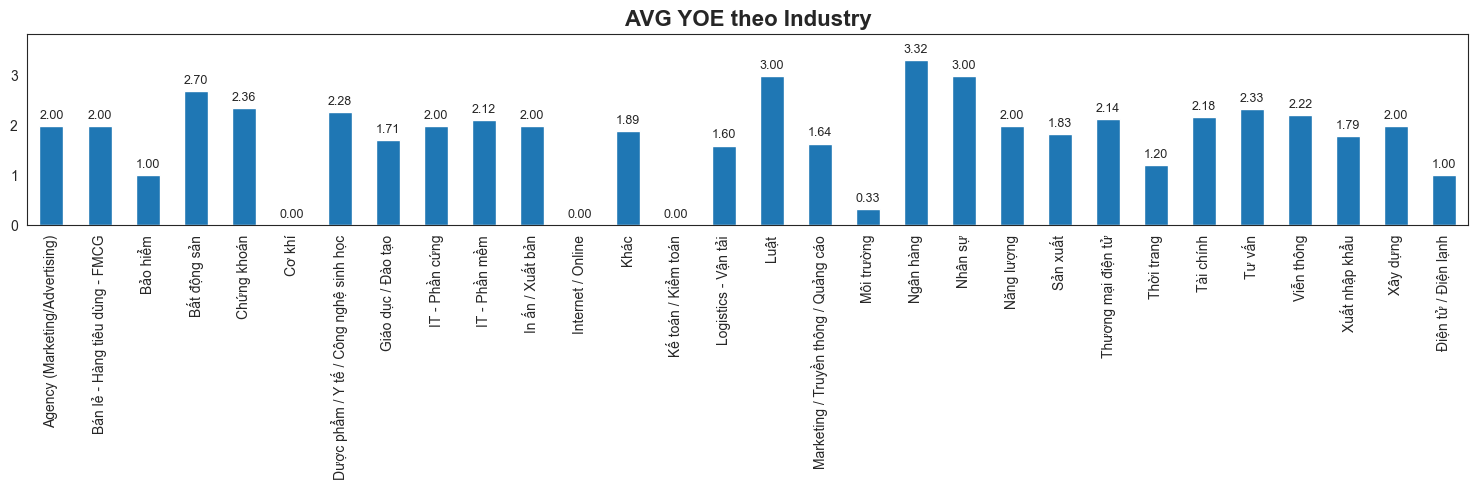

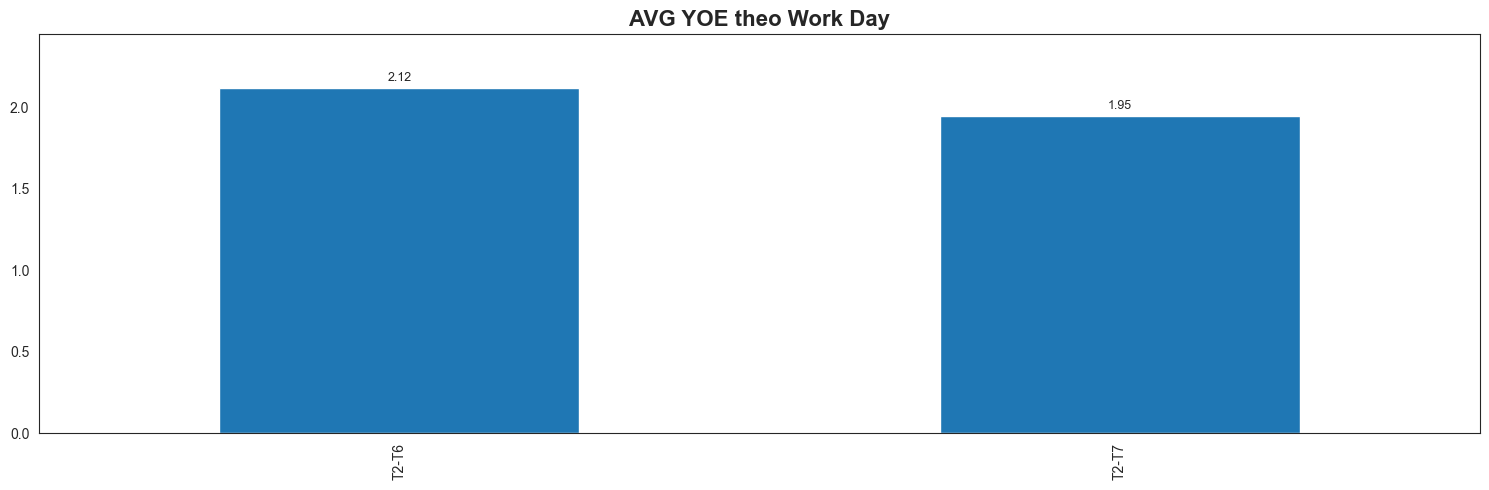

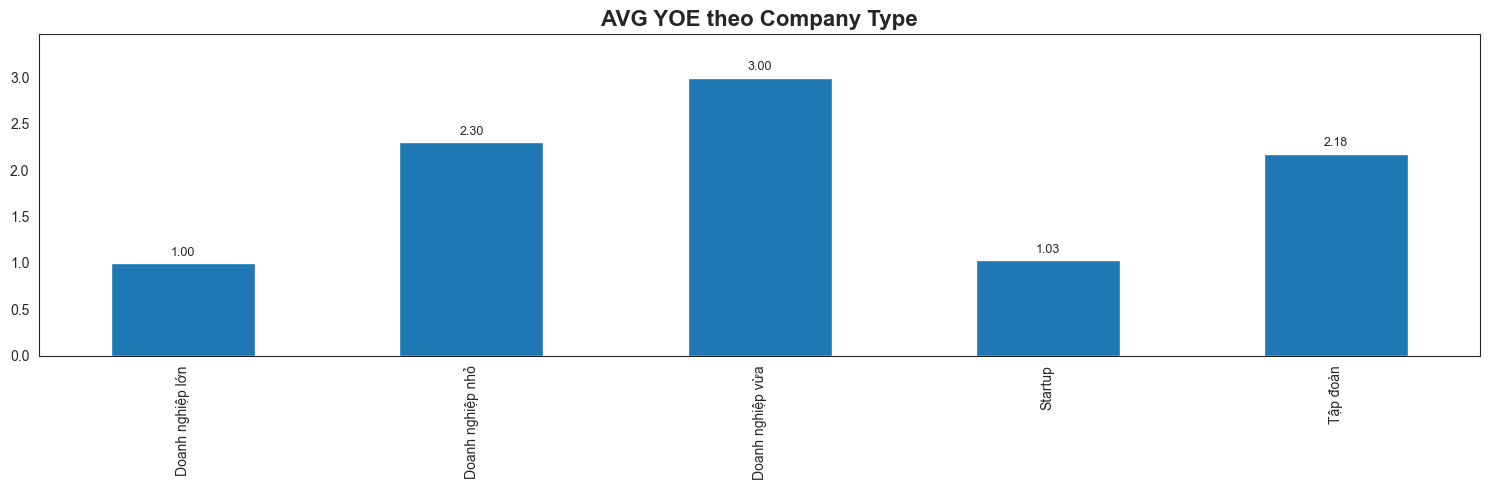

In [160]:
cols = ['Place', 'Industry', 'Work Day', 'Company Type']

for column in cols:
    calc_groupby = job_final.groupby(column).agg(
        avg_yoe=('YOE', 'mean')
    ).round(2).reset_index()

    

    fig, ax = plt.subplots(figsize=(15, 5))
    calc_groupby.plot(kind='bar', x=column, y='avg_yoe', ax=ax, legend=False)

    title = 'AVG YOE theo {}'.format(column)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9, padding=3)

    current_max_ylim = ax.get_ylim()[1]
    ax.set_ylim(0, current_max_ylim * 1.1)

    plt.tight_layout()
    plt.show()

In [167]:
job_df[job_df['Place'].isin(['Nhật Bản', 'Nước Ngoài'])]

,Index,Job Title,Salary,Place,YOE,Company,No Employee,Industry,Require Skill,Additional Skill,Schedule,Detail Description,Detail Requirement,Detail Benefit,URL,Salary MIN,Salary MAX,emp_min,Company Type,Work Day
63,1,Performance Analyst (Internal Control),Thoả thuận,Nước Ngoài,3.0,CÔNG TY TNHH ĐẦU TƯ TRUYỀN THÔNG GIẢI TRÍ GODI,25-99 nhân viên,Marketing / Truyền thông / Quảng cáo,Không yêu cầu,Không yêu cầu,Cách thức ứng tuyển\n\n ...,Mô tả công việc\n\n- Monitor advertising and o...,Yêu cầu ứng viên\n\n- Must have 3+ years of ex...,Quyền lợi\n\n- The company supports Visa.- Hou...,https://www.topcv.vn/viec-lam/performance-anal...,18.76,29.4,NaN,Tập đoàn,T2-T6
257,25,(JP 166) Kỹ Sư Phân Tích CAE Ô Tô,62 - 65 triệu,Nhật Bản,3.0,CTY TNHH R TECHNO VIỆT NAM,100-499 nhân viên,IT - Phần mềm,\nPhân Tích Phần Tử Hữu Hạn (fea)\nMô Phỏng Ca...,Không yêu cầu,Thời gian làm việc\n\nThứ 2 - Thứ 6 (từ 08:00 ...,Mô tả công việc\n\n・Nơi làm việc：Thành phố Toy...,Yêu cầu ứng viên\n\n◆Yêu cầu công việc・Trình đ...,"Quyền lợi\n\n- Hỗ trợ 100% thủ tục, chi phí, v...",https://www.topcv.vn/viec-lam/jp-166-ky-su-pha...,62.00,65.0,62.0,Doanh nghiệp vừa,T2-T6


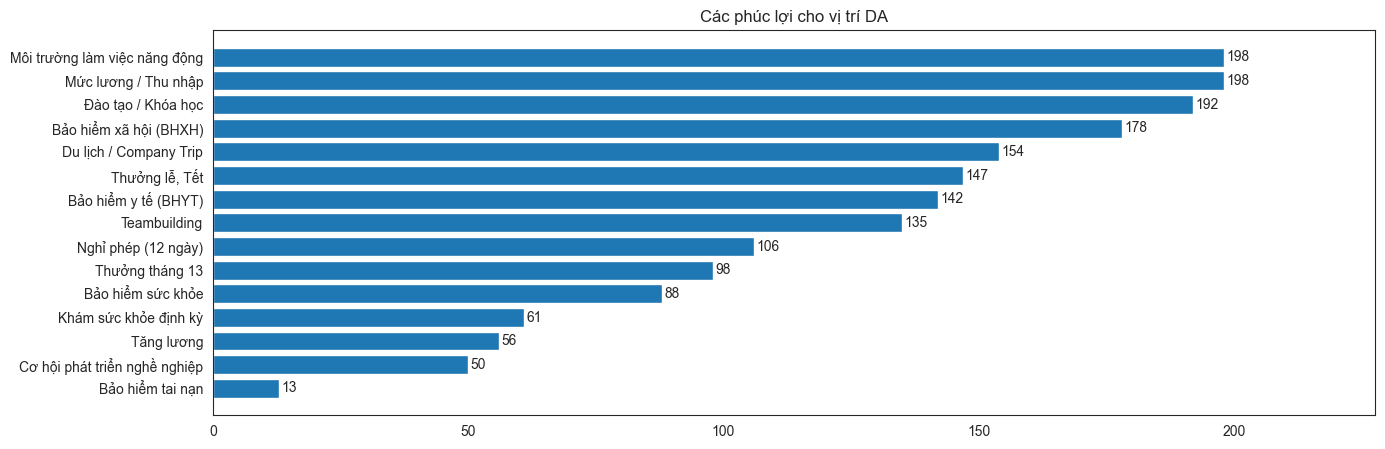

In [161]:
benefit_cols = list(benefit_patterns.keys())
count_benefits = job_df_benefit[benefit_cols].eq('Y').sum().sort_values(ascending=True)

plt.figure(figsize=(15,5))
bars = plt.barh(count_benefits.index,  count_benefits.values)

plt.title('Các phúc lợi cho vị trí DA')
plt.xlim(0, count_benefits.values.max() * 1.15)

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', ha='left', va='center')


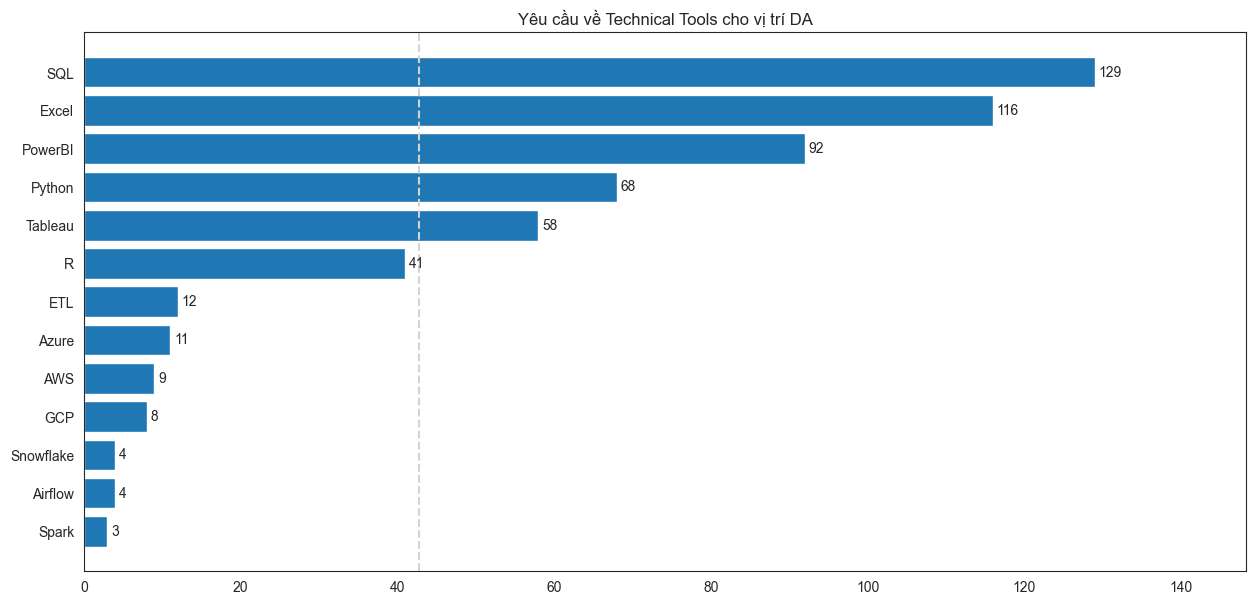

In [162]:
tool_cols = list(patterns.keys())
count_tools = job_df_tools[tool_cols].eq('Y').sum().sort_values(ascending=True)
average_tools = count_tools.mean()

plt.figure(figsize=(15,7))
bars = plt.barh(count_tools.index,  count_tools.values)
plt.axvline(x=average_tools, color='lightgrey', linestyle='--')

plt.title('Yêu cầu về Technical Tools cho vị trí DA')
plt.xlim(0, count_tools.values.max() * 1.15)

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', ha='left', va='center')